In [38]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [39]:
#Load the dataset
df = pd.read_csv('data.csv')
df.shape

(2240, 27)

In [40]:
df.head()

,customer_id,birth_year,education_level,marital_status,annual_income,num_children,num_teenagers,signup_date,days_since_last_purchase,has_recent_complaint,...,num_web_purchases,num_catalog_purchases,num_store_purchases,web_visits_last_month,accepted_campaign_1,accepted_campaign_2,accepted_campaign_3,accepted_campaign_4,accepted_campaign_5,accepted_last_campaign
0,5524,1957,Graduation,Single,58138.0,0,0.0,4/9/2012,58,0,...,8,10,4,7,0,0,0,0,0,1
1,2174,1954,Graduation,Single,46344.0,1,1.0,8/3/2014,38,0,...,1,1,2,5,0,0,0,0,0,0
2,4141,1965,Graduation,Together,71613.0,0,0.0,21-08-2013,26,0,...,8,2,10,4,0,0,0,0,0,0
3,6182,1984,Graduation,Together,26646.0,1,0.0,10/2/2014,26,0,...,2,0,4,6,0,0,0,0,0,0
4,5324,1981,PhD,Married,58293.0,1,0.0,19-01-2014,94,0,...,5,3,6,5,0,0,0,0,0,0


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               2240 non-null   int64  
 1   birth_year                2240 non-null   int64  
 2   education_level           2199 non-null   object 
 3   marital_status            2240 non-null   object 
 4   annual_income             2173 non-null   float64
 5   num_children              2240 non-null   int64  
 6   num_teenagers             2196 non-null   float64
 7   signup_date               2240 non-null   object 
 8   days_since_last_purchase  2240 non-null   int64  
 9   has_recent_complaint      2240 non-null   int64  
 10  spend_wine                2240 non-null   int64  
 11  spend_fruits              2240 non-null   int64  
 12  spend_meat                2240 non-null   int64  
 13  spend_fish                2240 non-null   int64  
 14  spend_sw

As we can notice, signup_date is not in Date type. There are missing values in Education level and income, and num_teenagers. There are some categorical features that will be encoded later into numbers.

In [42]:
df.dropna(inplace=True)
print("After dropping null values, the shape of the dataset is:", df.shape)

After dropping null values, the shape of the dataset is: (2090, 27)


In [43]:
df['signup_date']= pd.to_datetime(df['signup_date'], format= 'mixed')
dates = []

for i in df['signup_date']:
    i.date()
    dates.append(i)
# Dates in the list 

print("Oldest date", min(dates))
print("Latest date", max(dates))


Oldest date 2012-01-08 00:00:00
Latest date 2014-12-06 00:00:00


Now, lets create a customer loyalty amount, which calculates the days for each customer according to the newest customer joining the company.

In [44]:
days = [ ]

latestDateCustomer = max(dates)

for i in dates:
    difference = latestDateCustomer - i
    days.append(difference)

df['customer_loyalty_days'] = days
df['customer_loyalty_days'] = df['customer_loyalty_days'].dt.days

Now lets see the categorical values we have:

In [45]:
print("Total categories of marital status\n",df['marital_status'].value_counts(), "\n")
print("Total categories of education level\n",df['education_level'].value_counts(), "\n")


Total categories of marital status
 marital_status
Married     816
Together    535
Single      448
Divorced    215
Widow        70
Alone         3
YOLO          2
Absurd        1
Name: count, dtype: int64 

Total categories of education level
 education_level
Graduation    1052
PhD            449
Master         343
2n Cycle       195
Basic           51
Name: count, dtype: int64 



Now lets extract some new features 
- Extract Age of customer from date of birth
- Another feature that shows the total spent for the customer
- Children that calculates number of children
- Editing marital status to be Partner and Alone
- To show household impact, creating feature family size, and is_parent
- Lastly creating three categories of education to simplify it
- Dropping some redundant features



In [46]:
# Age Calculation
df['age'] = 2025 - df['birth_year']

# Total Spend Calculation
df['total_spend'] = df['spend_fish'] + df['spend_fruits']+df['spend_gold']+df['spend_meat']+df['spend_sweets']+ df['spend_wine']

# Marital Status Editing
df['living_with'] = df['marital_status'].replace({"Married":"Partner", "Together":"Partner", "Absurd": "Alone", "Widow": "Alone", "YOLO": "Alone", "Divorced":"Alone", "Single":"Alone"})

# Number of children
df['children']= df['num_children']+ df['num_teenagers']

#Family size
df['family_size']= df['children'] + df['living_with'].replace({"Alone":1, "Partner":2}).astype(int)


# Is parent?
df['isParent']= np.where(df['children']>0, 1, 0)

# Education Level
df['Education']= df['education_level'].replace({"Graduation":"Graduate", "PhD":"Postgraduate", "Master":"Postgraduate", "2n Cycle":"Undergraduate", "Basic":"Undergraduate"})

# Now columns to drop

columns_to_drop = ['customer_id', 'birth_year',  'marital_status', 'num_children', 'num_teenagers', 'signup_date', 'education_level']
df.drop(columns=columns_to_drop, inplace=True)


In [47]:
df.describe()

,annual_income,days_since_last_purchase,has_recent_complaint,spend_wine,spend_fruits,spend_meat,spend_fish,spend_sweets,spend_gold,num_discount_purchases,...,accepted_campaign_3,accepted_campaign_4,accepted_campaign_5,accepted_last_campaign,customer_loyalty_days,age,total_spend,children,family_size,isParent
count,2090.000000,2090.000000,2090.000000,2090.000000,2090.000000,2090.000000,2090.000000,2090.000000,2090.000000,2090.000000,...,2090.000000,2090.000000,2090.000000,2090.000000,2090.000000,2090.000000,2090.000000,2090.000000,2090.000000,2090.000000
mean,52243.827273,48.901435,0.009569,304.401435,26.064115,167.257416,37.523923,27.156459,43.947368,2.322010,...,0.072727,0.073684,0.073684,0.149761,512.212440,56.135407,606.350718,0.944498,2.590909,0.715311
std,25488.933171,29.041095,0.097377,338.208743,39.220232,224.792684,54.409460,41.313115,51.784860,1.924159,...,0.259750,0.261319,0.261319,0.356922,231.937307,11.953570,602.710265,0.745037,0.900302,0.451374
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,5.000000,0.000000,1.000000,0.000000
25%,34972.000000,24.000000,0.000000,23.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,341.000000,48.000000,68.000000,0.000000,2.000000,0.000000
50%,51369.000000,49.000000,0.000000,173.500000,8.000000,68.000000,12.000000,8.000000,24.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,513.000000,55.000000,396.500000,1.000000,3.000000,1.000000
75%,68464.500000,74.000000,0.000000,505.000000,32.750000,232.750000,50.000000,33.750000,57.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,686.000000,66.000000,1048.750000,1.000000,3.000000,1.000000
max,666666.000000,99.000000,1.000000,1493.000000,199.000000,1725.000000,258.000000,262.000000,321.000000,15.000000,...,1.000000,1.000000,1.000000,1.000000,1063.000000,132.000000,2525.000000,3.000000,5.000000,1.000000


There are some weird stuff I guess, the age max is 132, so lets see some plots to deep into the data more.

Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

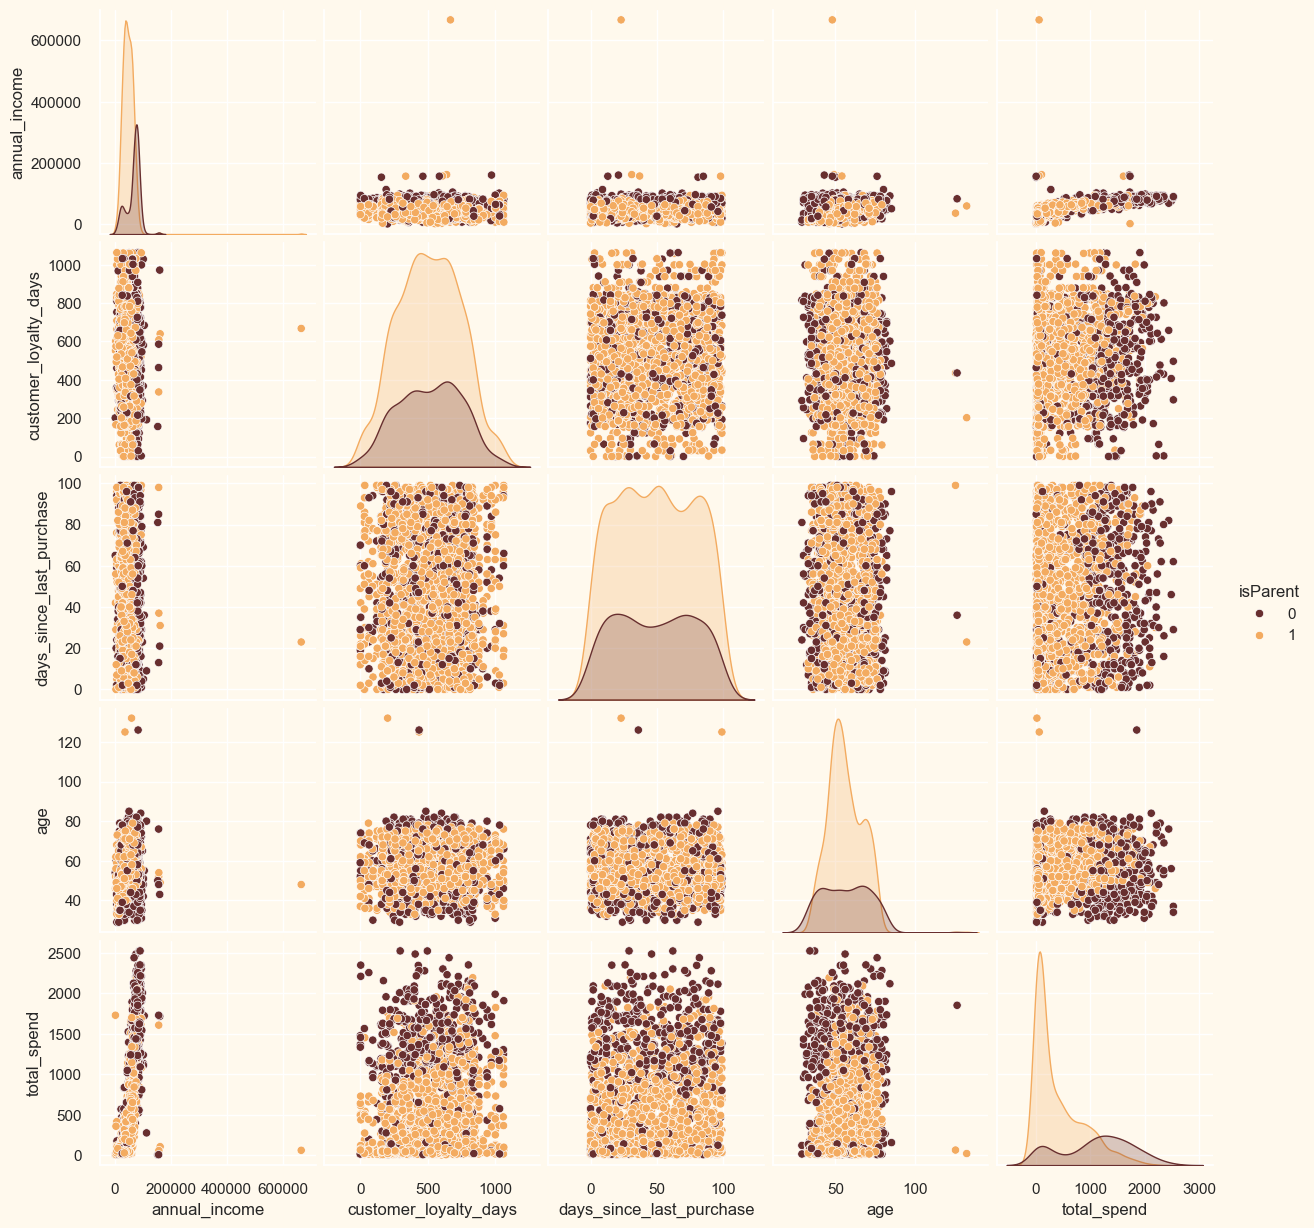

In [48]:
#To plot some selected features 
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "annual_income", "customer_loyalty_days", "days_since_last_purchase", "age", "total_spend", "isParent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")     
plt.figure()
sns.pairplot(df[To_Plot], hue= "isParent",palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

There are some outliers in income, and age.

In [50]:
df = df[(df['age']<90)]
df = df[(df['annual_income']<600000)]
print("After removing outliers, the shape of the dataset is:", df.shape)

After removing outliers, the shape of the dataset is: (2086, 28)


Now lets see the correlation between numerical features.

<Axes: >

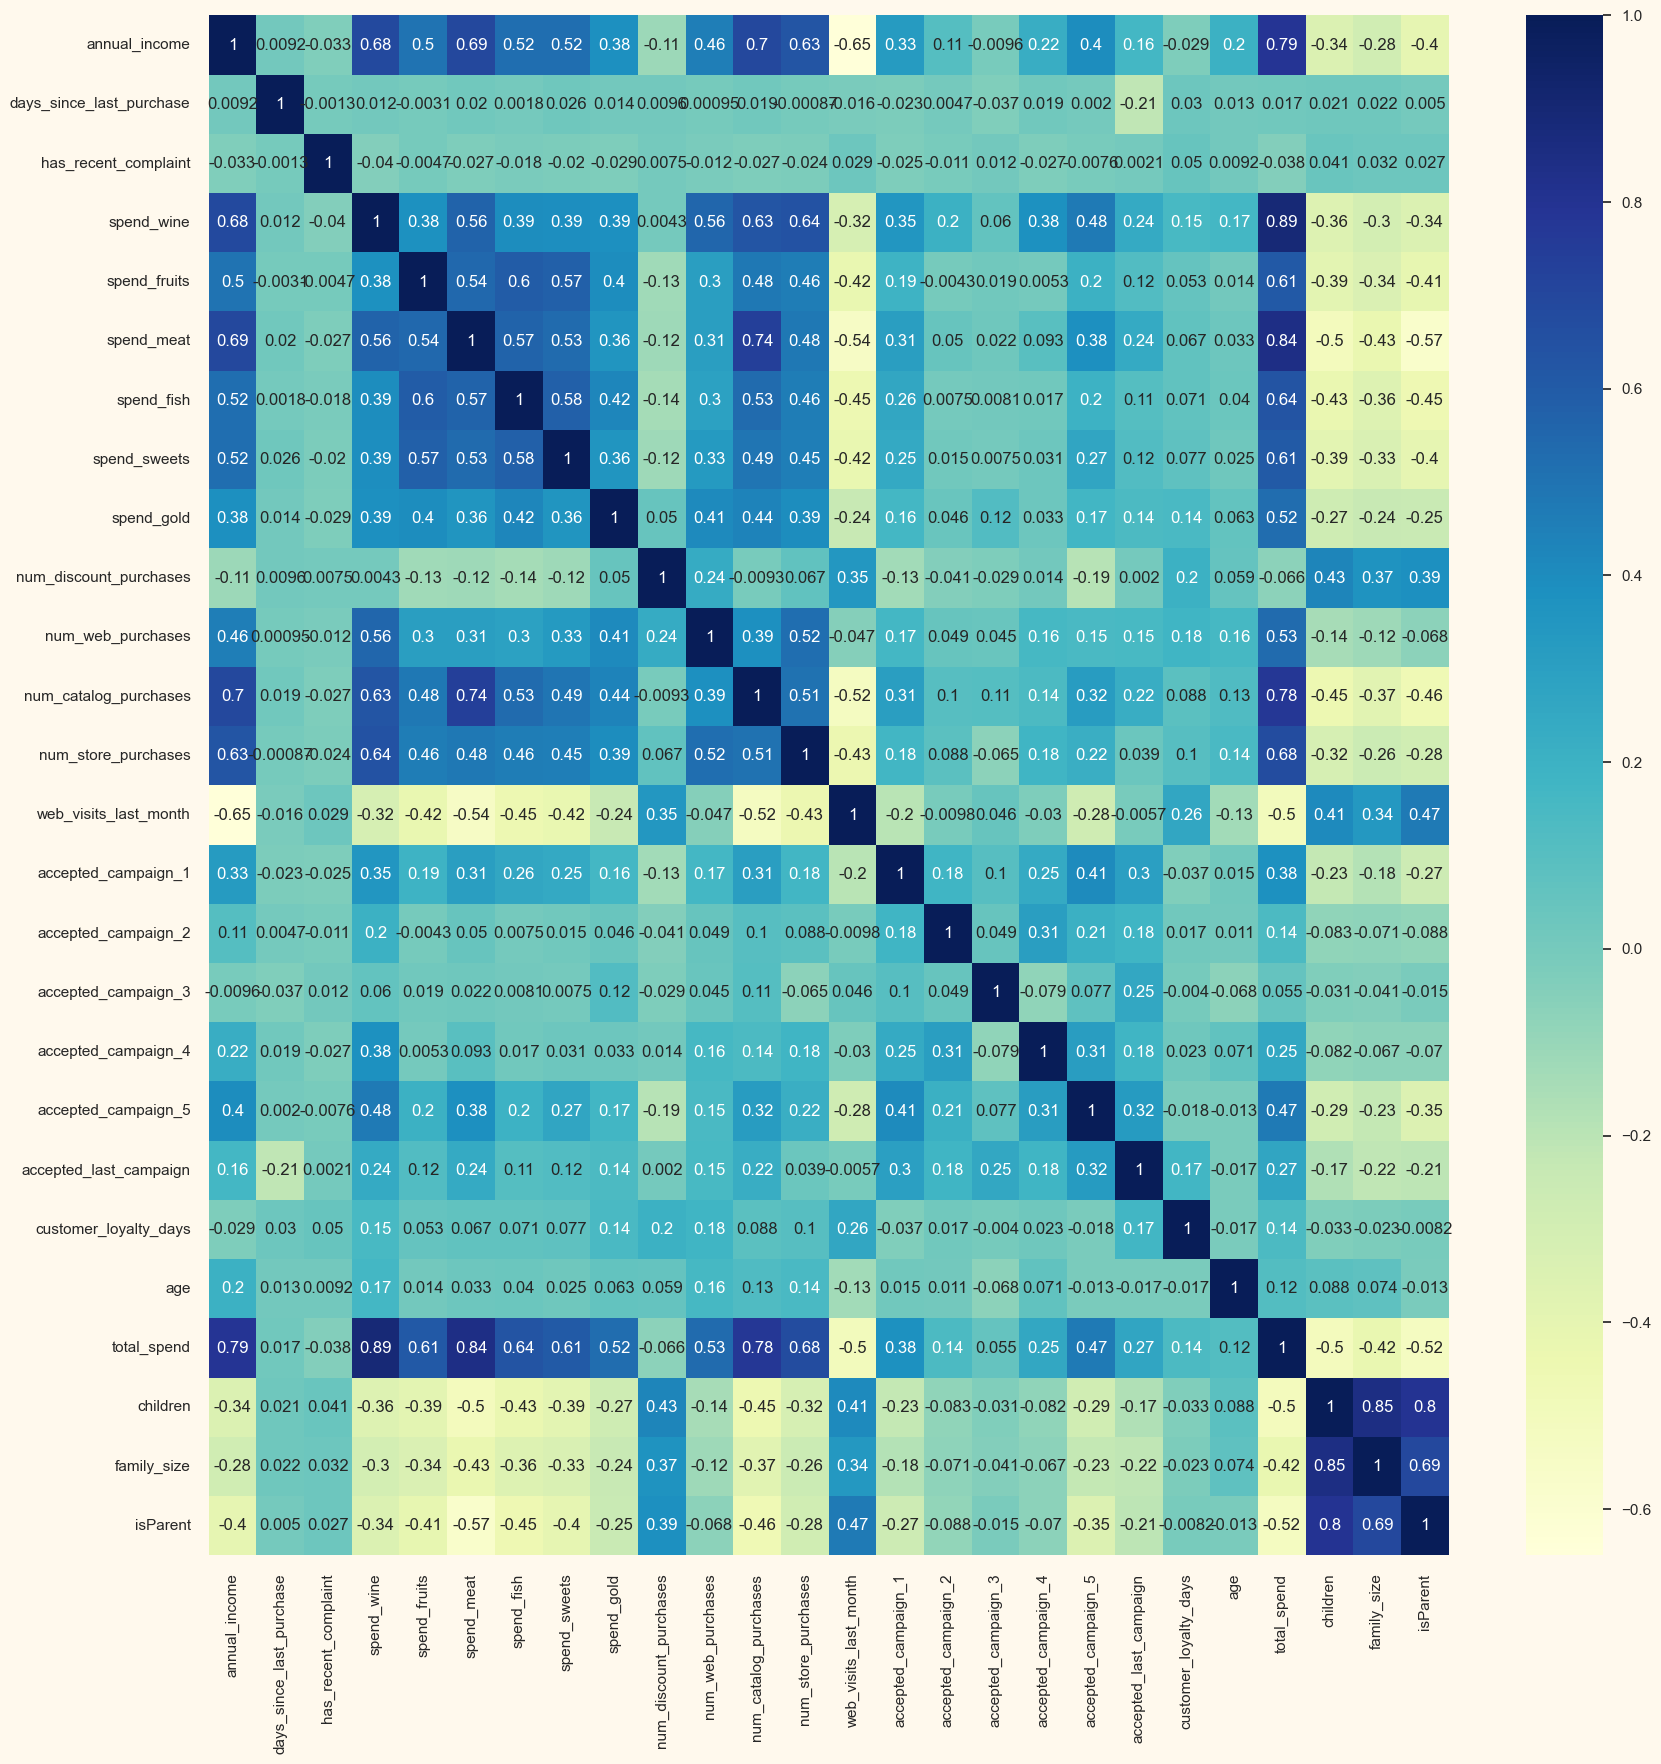

In [53]:
numeric_df = df.select_dtypes(include='number')
corrmatrix = numeric_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrmatrix, annot=True, cmap="YlGnBu")

Data Preprocessing:

In [56]:
categorical_df = df.select_dtypes(include='object').columns
print(categorical_df)

Index(['living_with', 'Education'], dtype='object')


In [57]:
# Label Encoding the categrorical features

LE = LabelEncoder()

for i in categorical_df:
    df[i]= LE.fit_transform(df[i])

print("All features are now numerical hehe.")

All features are now numerical hehe.


Lets also scale the data:

In [59]:
#Creating a copy of data
dc = df.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions 
"""

21  accepted_campaign_1       2240 non-null   int64  
 22  accepted_campaign_2       2240 non-null   int64  
 23  accepted_campaign_3       2240 non-null   int64  
 24  accepted_campaign_4       2240 non-null   int64  
 25  accepted_campaign_5       2240 non-null   int64  
 26  accepted_last_campaign

"""
cols_del = ['accepted_campaign_1', 'accepted_campaign_2', 'accepted_campaign_3', 'accepted_campaign_4', 'accepted_campaign_5', 'accepted_last_campaign']
dc = dc.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(dc)
scaled_dc = pd.DataFrame(scaler.transform(dc),columns= dc.columns )
print("All features are now scaled")

All features are now scaled


In [ ]:
#Scaled data to be used for reducing the dimensionality using PCA:
print("Dataframe to be used for further modelling:")
scaled_dc.head()

Dataframe to be used for further modelling:


,annual_income,days_since_last_purchase,has_recent_complaint,spend_wine,spend_fruits,spend_meat,spend_fish,spend_sweets,spend_gold,num_discount_purchases,...,num_store_purchases,web_visits_last_month,customer_loyalty_days,age,total_spend,living_with,children,family_size,isParent,Education
0,0.286311,0.313191,-0.095875,0.977132,1.582509,1.685316,2.470999,1.471909,0.853595,0.351717,...,-0.557183,0.696674,1.977172,1.027079,1.678050,-1.352920,-1.267802,-1.767174,-1.584861,-0.893266
1,-0.258323,-0.375780,-0.095875,-0.868342,-0.639380,-0.717789,-0.653021,-0.633427,-0.733789,-0.167888,...,-1.170686,-0.131160,-1.669880,1.284630,-0.962466,-1.352920,1.415744,0.453504,0.630970,-0.893266
2,0.908572,-0.789162,-0.095875,0.359016,0.586490,-0.179316,1.350027,-0.149441,-0.036888,-0.687493,...,1.283329,-0.545076,-0.173985,0.340274,0.281400,0.739142,-1.267802,-0.656835,-1.584861,-0.893266
3,-1.167955,-0.789162,-0.095875,-0.868342,-0.562763,-0.655486,-0.506008,-0.585028,-0.753147,-0.167888,...,-0.557183,0.282757,-1.928537,-1.290886,-0.919288,0.739142,0.073971,0.453504,0.630970,-0.893266
4,0.293469,1.553338,-0.095875,-0.389229,0.433256,-0.219367,0.155549,-0.004246,-0.559564,1.390928,...,0.056321,-0.131160,-0.824937,-1.033334,-0.306489,0.739142,0.073971,0.453504,0.630970,0.563617


In [61]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_dc)
PCA_dc = pd.DataFrame(pca.transform(scaled_dc), columns=(["col1","col2", "col3"]))
PCA_dc.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2086.0,-1.634998e-16,2.778905,-5.750960,-2.454080,-0.876607,2.296623,7.449270
col2,2086.0,5.109368e-17,1.546386,-4.184181,-1.069749,-0.162591,1.041971,6.032153
col3,2086.0,-2.895308e-17,1.207124,-3.710322,-0.877187,-0.061429,0.814552,6.317876


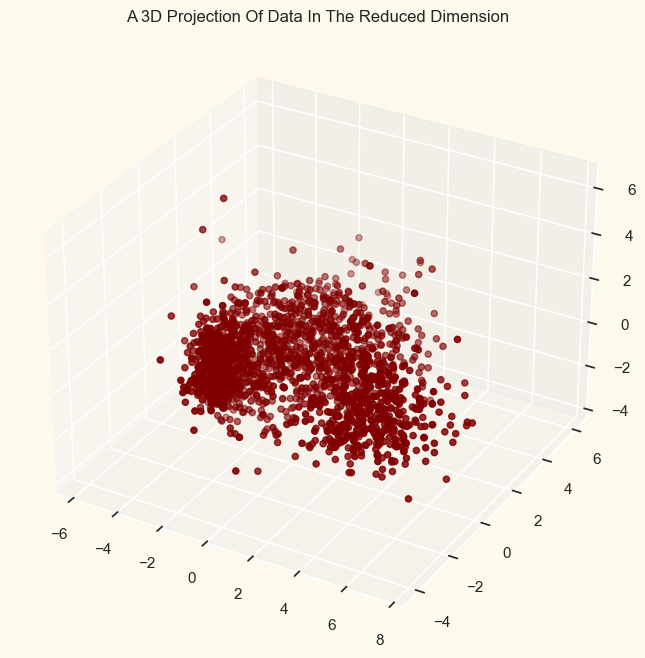

In [63]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_dc["col1"]
y =PCA_dc["col2"]
z =PCA_dc["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()